In [32]:
%load_ext autoreload
%autoreload 2

import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
import argparse
import json


# Ruta del entorno de trabajo
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

# Agregar rutas adicionales si es necesario
sys.path.append(os.path.abspath("../scripts"))
sys.path.append(os.path.abspath("../"))

# Configurar entorno de LaTeX para matplotlib
os.environ["PATH"] += ":/home/javitrucas/texlive/bin/x86_64-linux"
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": 'Nimbus Roman'
})

# Importar componentes de tu proyecto
from scripts.model import MILModel
from data.datasets.SCStandardMILDataset import SCStandardMILDataset
from data.datasets.MCStandardMILDataset import MCStandardMILDataset
from data.datasets.MCStandard_MIO import MCStandard_MIO
from data.datasets.FalseFrequencyMILDataset import FalseFrequencyMILDataset
from scripts.dataset_loader import load_dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from scripts.model import MILModel
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from data.datasets.SCStandardMILDataset import SCStandardMILDataset



# Nombre del dataset
ind_dataset_name = 'SCStandardMILDataset' 

# Configuración personalizada para tu entorno (ajusta si usas configuraciones distintas)
SAVE_PATH = f'/home/javitrucas/TFG/resultados/{ind_dataset_name}/'
os.makedirs(SAVE_PATH, exist_ok=True)

# Fijar semilla para reproducibilidad

torch.manual_seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


FUNCIONES UTILES

In [33]:
def config_from_run(run_path):
    # Carga configuración JSON local
    cfg_file = os.path.join(run_path, "config.json")
    with open(cfg_file, "r") as f:
        cfg = json.load(f)
    cfg.setdefault("loss_reduction", "mean")
    # Si tienes un campo 'model_config' como string
    if isinstance(cfg.get("model_config"), str):
        cfg["model_config"] = eval(
            cfg["model_config"], {"Namespace": argparse.Namespace}
        )
    return argparse.Namespace(**cfg)

def load_weights(model, run_path, device="cpu"):
    # Carga pesos desde un .pth local (puede ser best.pt o model.pth)
    weights_path = os.path.join(run_path, "weights", "best.pt")
    if not os.path.exists(weights_path):
        # si tu modelo está en models/rsna/model.pth
        weights_path = os.path.join("models/rsna", "model.pth")
    checkpoint = torch.load(weights_path, map_location=device)
    state_dict = checkpoint.get("state_dict", checkpoint)
    model.load_state_dict(state_dict, strict=False)
    return model.to(device).eval()

def instance_model_load_target_run_weights(run_path, device="cpu"):
    cfg   = config_from_run(run_path)
    model = MILModel(
        input_feature_dim=cfg.input_feature_dim,
        pooling_type=cfg.pooling_type,
        # añade aquí otros parámetros si tu constructor los pide
    ).to(device)
    return load_weights(model, run_path, device=device)

In [34]:
import torch
import torch.nn.functional as F

def msp_score(model, x, mask):
    """Maximum Softmax Probability: 1 − max p(y|x)."""
    model.eval()
    with torch.no_grad():
        logits, _ = model(x, mask=mask)
        probs = torch.sigmoid(logits)
        # Para clasificación binaria: p_pos = probs, p_neg = 1−probs
        p_max = torch.max(torch.cat([probs, 1-probs], dim=1), dim=1).values
    return (1 - p_max).cpu().numpy()

def energy_score(model, x, mask, T=1.0):
    """Energy-based score: −T · logsumexp(logits/T)."""
    model.eval()
    with torch.no_grad():
        logits, _ = model(x, mask=mask)
        e = -T * torch.logsumexp(logits / T, dim=1)
    return e.cpu().numpy()

def get_model_ood_scorers():
    """
    Devuelve un diccionario de funciones {nombre: scorer_fn}.
    Cada scorer_fn recibe (model, x, mask) y retorna array numpy de scores.
    """
    return {
        "MSP": msp_score,
        "Energy": energy_score,
        # puedes añadir más aquí: "Mahalanobis": mahalanobis_score, etc.
    }


EMPIEZA

In [35]:
# Cargar el modelo
# Parámetros
FEATURE_DIM = 128   # Dimensión de los features
NUM_BAGS    = 1000  # Nº de bolsas para train/test
B           = 10    # Instancias por bolsa

# Dataset de entrenamiento
train_dataset = SCStandardMILDataset(
    D=FEATURE_DIM,
    num_bags=NUM_BAGS,
    B=B,
    train=True
)

# Dataset de test
test_dataset = SCStandardMILDataset(
    D=FEATURE_DIM,
    num_bags=NUM_BAGS,
    B=B,
    train=False
)

# DataLoaders (batch_size=1 como antes)
train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=train_dataset.collate_fn
)
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=test_dataset.collate_fn
)

In [36]:
# Celda 2: Entrenamiento del modelo
# Configuración de entrenamiento
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
POOLING = 'attention'   # 'mean' o 'max'
LR      = 1e-3
EPOCHS  = 10

# Instanciar modelo, pérdida y optimizador
model     = MILModel(input_feature_dim=FEATURE_DIM, pooling_type=POOLING).to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Bucle de entrenamiento
for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    for X, Y, _, adj, mask in train_loader:
        X, Y, mask = X.to(DEVICE), Y.float().unsqueeze(1).to(DEVICE), mask.to(DEVICE)
        logits, _ = model(X, mask=mask)
        probs = torch.sigmoid(logits)
        loss = criterion(probs, Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}/{EPOCHS} — Loss: {avg_loss:.4f}")
    
# Guardar pesos entrenados
save_dir = './models/scstandard'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'model_attn.pth')

# Guardar pesos entrenados
torch.save(model.state_dict(), save_path)
print(f"Modelo guardado en {save_path}")

Epoch 1/10 — Loss: 0.1567
Epoch 2/10 — Loss: 0.0434
Epoch 3/10 — Loss: 0.0222
Epoch 4/10 — Loss: 0.0178
Epoch 5/10 — Loss: 0.0131
Epoch 6/10 — Loss: 0.0070
Epoch 7/10 — Loss: 0.0049
Epoch 8/10 — Loss: 0.0064
Epoch 9/10 — Loss: 0.0049
Epoch 10/10 — Loss: 0.0151
Modelo guardado en ./models/scstandard/model_attn.pth


In [37]:
# Celda 3: Evaluación + OOD scoring
# 1. Evaluación en test (como antes)
model.load_state_dict(torch.load('models/scstandard/model_attn.pth', map_location=DEVICE))
model.eval()

all_labels, all_probs, all_preds = [], [], []
with torch.no_grad():
    for X, Y, _, adj, mask in test_loader:
        X, Y, mask = X.to(DEVICE), Y.to(DEVICE), mask.to(DEVICE)
        logits, _ = model(X, mask=mask)
        probs = torch.sigmoid(logits).cpu().squeeze().tolist()
        probs = probs if isinstance(probs, list) else [probs]
        preds = [int(p > 0.5) for p in probs]
        all_labels.extend([int(Y.item())])
        all_probs.extend(probs)
        all_preds.extend(preds)

acc = accuracy_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)
f1  = f1_score(all_labels, all_preds)
cm  = confusion_matrix(all_labels, all_preds)

print(f"Test — Acc: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")
print("Confusion Matrix:\n", cm)

# 2. Cálculo de OOD scores

ood_scorers = get_model_ood_scorers()
# Ejemplo: computar MSP y Energy para todo el test set
scores = {name: [] for name in ood_scorers}
with torch.no_grad():
    for X, _, _, adj, mask in test_loader:
        X, mask = X.to(DEVICE), mask.to(DEVICE)
        for name, fn in ood_scorers.items():
            sc = fn(model, X, mask)  # retorna numpy array (batch_size,)
            scores[name].extend(sc.tolist())

for name, sc_list in scores.items():
    print(f"OOD scores [{name}]: mean={np.mean(sc_list):.4f}, std={np.std(sc_list):.4f}")


/tmp/ipykernel_1571892/3453336396.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/scstandard/model_attn.pth', map_location=DEVIC

Test — Acc: 0.0040, AUC: 0.0021, F1: 0.0060
Confusion Matrix:
 [[  1 499]
 [497   3]]
OOD scores [MSP]: mean=0.0276, std=0.0563
OOD scores [Energy]: mean=26.1688, std=33.6455


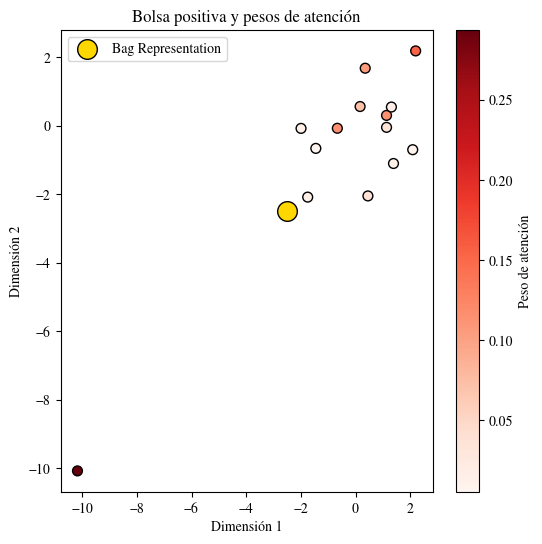

In [38]:
# Celda: Visualizar un ejemplo positivo con atención
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# 1. Encontrar primera bolsa positiva
for X_batch, Y_batch, _, adj_mat, mask in test_loader:
    if Y_batch.item() == 1:
        X_pos, Y_pos, adj_pos, mask_pos = X_batch, Y_batch, adj_mat, mask
        break

# 2. Mover a DEVICE y pasar por el modelo
X_pos = X_pos.to(DEVICE)        # (1, bag_size, feature_dim)
mask_pos = mask_pos.to(DEVICE)

# Forward para atención
model.eval()
with torch.no_grad():
    logits, attn_weights = model(X_pos, mask=mask_pos)
    bag_repr = model.classifier.in_features  # no es necesario, usamos bag_repr interno
    # Para extraer bag_repr necesitamos hack: volvemos a replicar forward parcialmente:
    # Pero más sencillo: modificamos forward para que devuelva bag_repr.
    # Como workaround: vamos a reimplementarlo aquí:
    # Extraer features y pooling manual:
    features = X_pos  # dado preextraído
    attn_w = attn_weights  # (1, bag_size)
    bag_repr = torch.bmm(attn_w.unsqueeze(1), features).squeeze(1)  # (1, feature_dim)

# Convertir a numpy
X_np = X_pos.squeeze(0).cpu().numpy()        # (bag_size, feature_dim)
Z_np = bag_repr.squeeze(0).cpu().numpy()     # (feature_dim,)
attn_np = attn_w.squeeze(0).cpu().numpy()    # (bag_size,)

# 3. Plot 
plt.figure(figsize=(6,6))
# Instancias con color según atención
sc = plt.scatter(
    X_np[:,0], X_np[:,1],
    c=attn_np, cmap='Reds', s=50, edgecolors='k'
)
plt.colorbar(sc, label='Peso de atención')
# Representación de la bolsa
plt.scatter(Z_np[0], Z_np[1], c='gold', edgecolors='k', s=200, label='Bag Representation')
plt.legend()
plt.title("Bolsa positiva y pesos de atención")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.show()


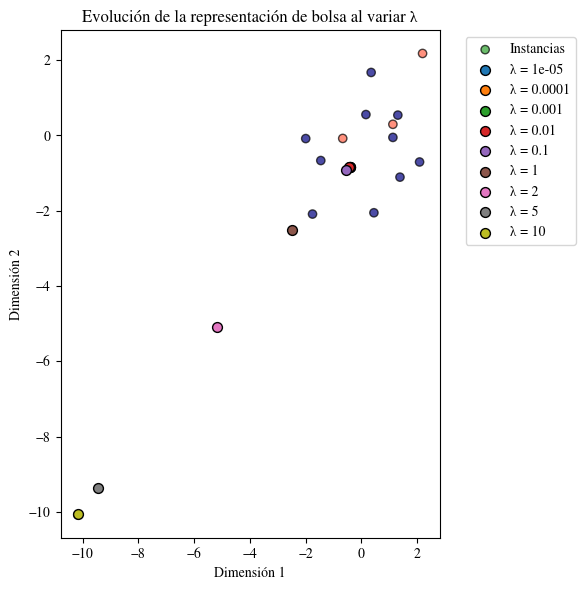

In [39]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Desactivar LaTeX para evitar errores si no está instalado
mpl.rcParams['text.usetex'] = False  

# 1. Encontrar primera bolsa positiva
for X_batch, Y_batch, y_inst_batch, adj_mat_batch, mask_batch in test_loader:
    if Y_batch.item() == 1:
        X_pos, y_inst_pos, adj_mat_pos, mask_pos = (
            X_batch, y_inst_batch, adj_mat_batch, mask_batch
        )
        break

# Convertir a numpy para el scatter de instancias
X_np       = X_pos.squeeze(0).cpu().numpy()       # (bag_size, feature_dim)
y_inst_np  = y_inst_pos.squeeze(0).cpu().numpy()   # (bag_size,)

# Colores por etiqueta de instancia
colors = {0: 'navy', 1: 'tomato', -1: 'tab:green'}

plt.figure(figsize=(6,6))
plt.scatter(
    X_np[:, 0], X_np[:, 1],
    c=[colors[int(i)] for i in y_inst_np],
    alpha=0.7, edgecolors='k',
    label='Instancias'
)

# 2. Bucle sobre distintos valores de lambda_exp
lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 5, 10]
for lamb in lambdas:
    # Reemplazar temporalmente el forward de attention para escalar scores por lambda
    def scaled_attention_forward(self, features, mask=None):
        scores = self.attention_layer(features).squeeze(-1)
        if mask is not None:
            scores = scores.masked_fill(~mask.bool(), float('-inf'))
        # Escalar por lambda antes de softmax
        scores = scores * lamb
        weights = F.softmax(scores, dim=1)
        bag = torch.bmm(weights.unsqueeze(1), features).squeeze(1)
        return bag, weights

    # Monkey-patch del método forward de attention
    orig_forward = model.attention.forward
    model.attention.forward = scaled_attention_forward.__get__(model.attention, type(model.attention))

    # Calcular la representación de la bolsa con este lambda
    model.eval()
    with torch.no_grad():
        feats = X_pos.to(DEVICE)
        mask_d = mask_pos.to(DEVICE)
        bag_repr, _ = model.attention(feats, mask=mask_d)
        Z = bag_repr.squeeze(0).cpu().numpy()  # (feature_dim,)

    # Restaurar el forward original
    model.attention.forward = orig_forward

    # Plot de Z en las dos primeras dimensiones
    plt.scatter(
        Z[0], Z[1],
        edgecolors='k', s=50,
        label=f'λ = {lamb:g}'
    )

# Leyenda y formato
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Evolución de la representación de bolsa al variar λ")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.tight_layout()
plt.show()


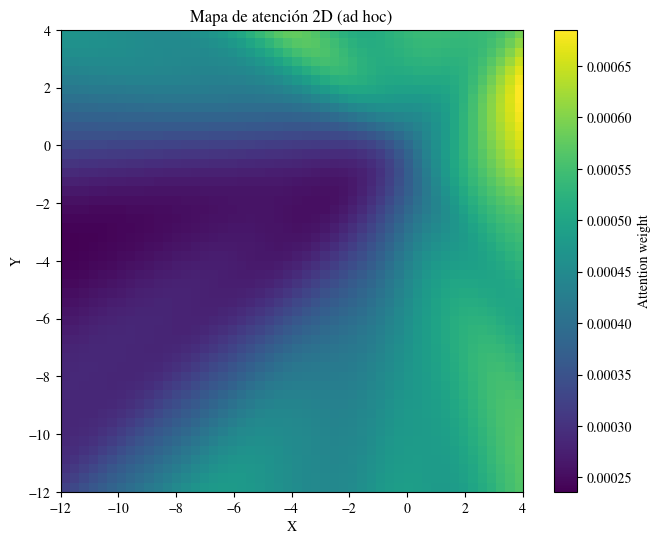

In [40]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scripts.model import AttentionMechanism  # o la ruta donde la definas

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1) Define un nuevo AttentionMechanism para 2D
att2d = AttentionMechanism(input_dim=2, hidden_dim=64).to(device)

# 2) Fijar lambda
lambda_val = 1.0

# 3) Crear rejilla
grid_size = 50
x_min, x_max = -12, 4
y_min, y_max = -12, 4
x_vals = torch.linspace(x_min, x_max, grid_size)
y_vals = torch.linspace(y_min, y_max, grid_size)
gx, gy = torch.meshgrid(x_vals, y_vals, indexing='xy')
points = torch.stack([gx.flatten(), gy.flatten()], dim=-1).unsqueeze(0).to(device)  # (1,N,2)
mask   = torch.ones(1, points.size(1), dtype=torch.bool, device=device)

# 4) Calcular atención
with torch.no_grad():
    scores = att2d.attention_layer(points).squeeze(-1)   # (1,N)
    scores = scores.masked_fill(~mask, float('-inf'))
    scores = scores * lambda_val
    weights = F.softmax(scores, dim=1)                   # (1,N)

# 5) Remodelar y plot
attn_map = weights.cpu().numpy().reshape(grid_size, grid_size)
plt.figure(figsize=(8,6))
plt.imshow(attn_map, extent=[x_min, x_max, y_min, y_max],
           origin='lower', cmap='viridis')
plt.colorbar(label='Attention weight')
plt.title("Mapa de atención 2D (ad hoc)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
